In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c
from scipy.optimize import newton

from astro530 import partition, saha_phi, KH, P_e, KH_bf, KH_ff, KHminus_bf, KHminus_ff

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

In [3]:
u_table = pd.read_table('./data/RepairedPartitionFunctions.txt', header=None, na_values='-', delim_whitespace=True)
u_table = u_table.set_index(0)

i_table = pd.read_table('./data/nist_ioniz.txt', header=None , delim_whitespace= True)
i_table = i_table.set_index(1)

A_table = pd.read_table('./data/SolarAbundance.txt', delim_whitespace= True)
A_table.dropna(inplace=True)

elements = A_table['element'].to_list()
elements.remove('Cs')

A_table = A_table.set_index('element')

### 18. The VALIIIC Atmosphere

In [4]:
VALIIIC = np.loadtxt('./data/VALIIIC_sci_e.txt').T
h = VALIIIC[0] 

T = VALIIIC[3] * u.K
nH = VALIIIC[5] * u.cm**-3
ne = VALIIIC[6] * u.cm**-3
Pg = VALIIIC[7] * VALIIIC[8] * u.barye

nH_800 = nH[np.argmin(np.abs(h - 800))]
ne_800 = ne[np.argmin(np.abs(h - 800))]
T_800 = T[np.argmin(np.abs(h - 800))]

In [5]:
Pe = (ne * c.k_B * T).to(u.barye)
Phi = saha_phi('H', T, i_table, u_table)

In [6]:
def n_pro(T, ne, nH):
    Pe = (ne * c.k_B * T).to(u.barye)
    Phi = saha_phi('H', T, i_table, u_table)
    return ((Phi / Pe)/(1 + Phi / Pe)) * nH

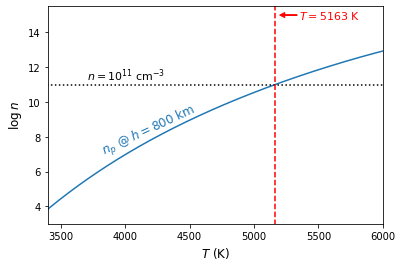

In [7]:
T_try = np.linspace(T_800 + 1300 * u.K, T_800 - 2000 * u.K, 1000)
np_try = u.Quantity([n_pro(T_try[i], ne_800, nH_800) for i in range(len(T_try))])

temp = T_try[np.argmin(np.abs(np_try.value - 1e11))]

plt.plot(T_try, np_try, label=r'$n_p\,(h=800$ km)')
plt.text(3700, 10**11.3, '$n = 10^{11}$ cm$^{-3}$', size = 11)
plt.hlines(1e11, 3300, 6500, 'k',':')
plt.text(3800, 10**7, r'$n_p$ @ $h=800$ km', size = 12, color = 'C0', rotation=25)
plt.vlines(temp.value, 1e2, 1e17, 'r','--')
plt.annotate('$T=${:.0f}'.format(temp), (5200, 10**15),  color='r', size=11, xytext=(5350, 1e15),  
             arrowprops=dict(width=0.5, headwidth=5, headlength=5,color ='r'), verticalalignment='center')



plt.xlim(3400, 6000)
plt.ylim(1e3, 10**15.5)
#plt.legend()
plt.semilogy()
plt.yticks(np.logspace(4, 14, 6), ['4','6','8','10','12','14'])

plt.xlabel('$T$ (K)')
plt.ylabel('$\log n$')
plt.savefig('ion_temp.png', bbox_inches='tight')

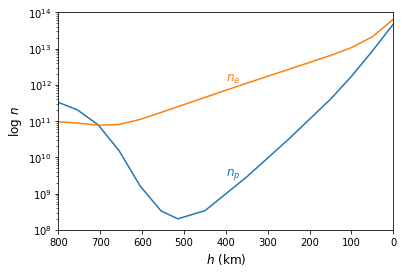

In [8]:
n_p = u.Quantity([n_pro(T[i], ne[i], nH[i]) for i in range(len(T))])

plt.plot(h, n_p)
plt.plot(h, ne)
plt.semilogy()
plt.xlim(800, 0)
plt.ylim(1e8, 1e14)
plt.xlabel('$h$ (km)')
plt.ylabel('$\log\, n$')
plt.text(400, 10**9.5, '$n_p$', color='C0',size=12)
plt.text(400, 10**12.1, '$n_e$', color='C1',size=12)
plt.show()

In [9]:
Pe = u.Quantity([P_e(T[i], Pg[i], A_table, i_table, u_table, elements) for i in range(len(T))])

In [10]:
def ne_j(element):
    nj = A_table['A'].loc[element] * nH
    Phi_j = saha_phi(element, T, i_table, u_table)
    ne_j = ((Phi_j / Pe)/(1 + Phi_j / Pe)) * nj
    return ne_j.to(u.cm**-3)

ne_calc = (Pe / (c.k_B * T)).cgs
ne_H =  ne_j('H')
ne_Fe = ne_j('Fe')
ne_Mg = ne_j('Mg')
ne_Si = ne_j('Si')

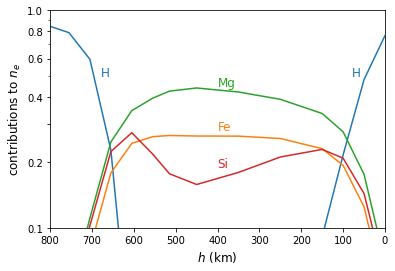

In [11]:
plt.plot(h, ne_H/ne_calc, label = 'H')
plt.text(680, 0.5, 'H', color='C0', size=12)
plt.text(80, 0.5, 'H', color='C0', size=12)
plt.plot(h, ne_Fe/ne_calc, label = 'Fe')
plt.text(400, 0.28, 'Fe', color='C1', size=12)
plt.plot(h, ne_Mg/ne_calc, label = 'Mg')
plt.text(400, 0.45, 'Mg', color='C2', size=12)
plt.plot(h, ne_Si/ne_calc, label = 'Si')
plt.text(400, 0.19, 'Si', color='C3', size=12)
plt.semilogy()
plt.xlim(800, 0)
plt.ylim(0.1, 1)
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0), labels=(0.1, 0.2, '', 0.4, 0.6, 0.8, 1.0))
plt.xlabel('$h$ (km)')
plt.ylabel('contributions to $n_e$')
#plt.legend(loc = (1.05, 0.35))
plt.show()

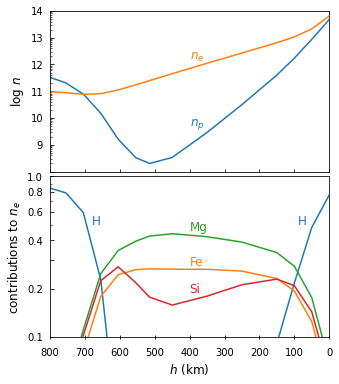

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (5,6), gridspec_kw={'hspace' : 0.03})

ax1.plot(h, n_p)
ax1.plot(h, ne)
ax1.semilogy()
ax1.set_xlim(800, 0)
ax1.set_ylim(1e8, 1e14)
ax1.set_xlabel('$h$ (km)')
ax1.set_ylabel('$\log\, n$')
ax1.text(400, 10**9.7, '$n_p$', color='C0',size=12)
ax1.text(400, 10**12.2, '$n_e$', color='C1',size=12)
ax1.set_xticklabels(())
ax1.set_yticks(np.logspace(8, 14, 7), ['','9','10','11','12','13','14'])
ax1.tick_params(which='both', pad=7, direction='in')

ax2.plot(h, ne_H/ne_calc, label = 'H')
ax2.text(680, 0.5, 'H', color='C0', size=12)
ax2.text(90, 0.5, 'H', color='C0', size=12)
ax2.plot(h, ne_Fe/ne_calc, label = 'Fe')
ax2.text(400, 0.28, 'Fe', color='C1', size=12)
ax2.plot(h, ne_Mg/ne_calc, label = 'Mg')
ax2.text(400, 0.46, 'Mg', color='C2', size=12)
ax2.plot(h, ne_Si/ne_calc, label = 'Si')
ax2.text(400, 0.19, 'Si', color='C3', size=12)
ax2.semilogy()
ax2.set_xlim(800, 0)
ax2.set_ylim(0.1, 1)
ax2.set_yticks((0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0), labels=(0.1, 0.2, '', 0.4, 0.6, 0.8, 1.0))
#ax2.tick_params(which='both', direction='in')
ax2.tick_params('x', pad=9, direction='inout')
ax2.tick_params('y', which='both', pad=7, direction='in')
ax2.set_xlabel('$h$ (km)')
ax2.set_ylabel('contributions to $n_e$')
plt.savefig('rutten_8.8.png', bbox_inches='tight')

### 19. Opacity and Pressure in the VALIIIC Atmosphere

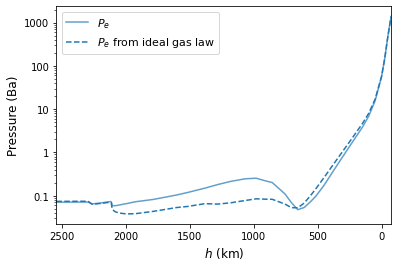

In [13]:
Pe_ideal = (ne * c.k_B * T).to(u.barye)
plt.plot(h, Pe, label='$P_e$', alpha=0.7)
plt.plot(h, Pe_ideal, 'C0--', label = '$P_e$ from ideal gas law')
plt.semilogy()
xlim = plt.xlim()
plt.xlim(xlim[1], xlim[0])
plt.yticks([0.1,1,10,100,1000],labels=[0.1,1,10,100,1000])
plt.xlabel(r'$h$ (km)')
plt.ylabel('Pressure (Ba)')
plt.legend(loc = 'upper left')
plt.savefig('electron_pressure.png', bbox_inches='tight')
plt.show()

In [16]:
def K_e(Pg, Pe, A):
    a_e = c.sigma_T
    return (a_e * Pe /(Pg-Pe) * np.sum(A)).cgs

def K_total(l, T, Pg,  A_table = A_table, i_table = i_table, u_table = u_table, elements = elements):
#    print('===========================================================================')
#    print('T = {:.0f}'.format(T))
    Pe = P_e(T, Pg, A_table, i_table, u_table, elements)
#    print('P_e = {:.1f}'.format(Pe))
#    print('P_g = {:g}'.format(Pg))
#    print('lambda = {:.1f}'.format(l))
#    print('Stimulated emission factor = {:.4f}'.format(1 - np.exp(-c.h * c.c / (l * c.k_B * T))))
    Phi_H = saha_phi('H', T, i_table, u_table)
    
    neutral_H = 1 / (1 + Phi_H / Pe)
#    print('Neutral Hydrogren Fraction = {:.7f}'.format(neutral_H))
    
    K_hydrogen = KH(l, T, Pe, i_table)
    
    A_j = A_table.loc[elements]['A'].to_numpy()
    mmm = np.sum(A_table.loc[elements]['A'] * A_table.loc[elements]['weight'] * u.u).cgs
#    print('Sum(A_j mu_j) = {:.4e}'.format(mmm))
    
#    print('===========================================================================')
    
    K_electron = K_e(Pg, Pe, A_j)
    total_per_H = K_hydrogen * neutral_H + K_electron
    total_per_g = total_per_H / mmm
#    print('K(continuum) = {:.4g}'.format(total_per_g))
#    print('===========================================================================')
#    print('K(H-_bf) = {:.4g}'.format(KHminus_bf(l, T, Pe) * neutral_H / mmm))
#    print('K(H-_ff) = {:.4g}'.format(KHminus_ff(l, T, Pe) * neutral_H / mmm * (1 - np.exp(-c.h * c.c / (l * c.k_B * T)))))
#    print('K(H_bf) = {:.4g}'.format(KH_bf(l, T, i_table) * neutral_H / mmm * (1 - np.exp(-c.h * c.c / (l * c.k_B * T)))))
#    print('K(H_ff) = {:.4g}'.format(KH_ff(l, T, i_table) * neutral_H / mmm * (1 - np.exp(-c.h * c.c / (l * c.k_B * T)))))
#    print('K(e-) = {:.4g}'.format(K_electron / mmm))
    return total_per_g

In [17]:
K1 = K_total(5000 * u.AA, 6420 * u.K, 1.13e5 * u.barye, A_table, i_table, u_table, elements)

In [18]:
10**2.76

575.4399373371566

In [19]:
K2 = K_total(1.5 * u.micron, 11572 * u.K, 1259 * u.barye, A_table, i_table, u_table, elements)

In [20]:
h = VALIIIC[0] * u.km
T = VALIIIC[3] * u.K
nH = VALIIIC[5] * u.cm**-3
ne = VALIIIC[6] * u.cm**-3
Pg = VALIIIC[7] * VALIIIC[8] * u.barye

n = np.sum(A_table.loc[elements]['A']) * nH
mmm = np.sum(A_table.loc[elements]['A'] * A_table.loc[elements]['weight'] * u.u).cgs

opacity = u.Quantity([K_total(500 * u.nm, T[i], Pg[i]) for i in range(len(T))])

In [21]:
tau_500 = VALIIIC[2]

<ipython-input-22-d20061e58d51>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tau_500), opacity.value)


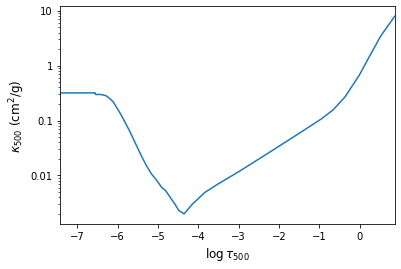

In [22]:
plt.plot(np.log10(tau_500), opacity.value)
plt.semilogy()
plt.xlabel(r'$\log \tau_{500}$')
plt.ylabel(r'$\kappa_{500}$ (cm$^2$/g)')
plt.yticks([1e-2, 1e-1, 1, 10],['0.01', '0.1', '1', '10'])
plt.savefig('problem19_d.png', bbox_inches='tight')
plt.show()

In [23]:
dtau = np.diff(tau_500)
tau_avg = (tau_500[1:] + tau_500[:-1])/2
dPg = np.diff(Pg)
g = 10 ** 4.4377 * u.cm / u.s ** 2

kappa0 = g * dtau / dPg

<ipython-input-24-3464b5daa53a>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tau_500), opacity, label='Part d')


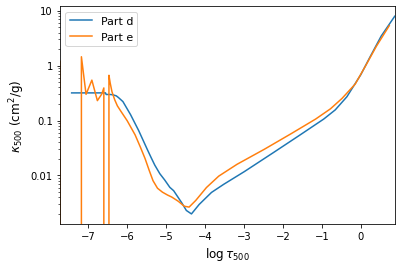

In [24]:
plt.plot(np.log10(tau_500), opacity, label='Part d')
plt.plot(np.log10(tau_avg), kappa0, label='Part e')
plt.semilogy()
plt.xlabel(r'$\log \tau_{500}$')
plt.ylabel(r'$\kappa_{500}$ (cm$^2$/g)')
plt.yticks([1e-2, 1e-1, 1, 10],['0.01', '0.1', '1', '10'])
plt.legend()
plt.savefig('problem19_e.png', bbox_inches='tight')
plt.show()

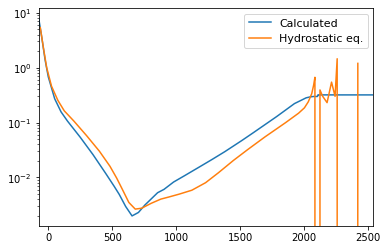

In [29]:
plt.plot(h, opacity, label='Calculated')
plt.plot((h[1:]+h[:-1])/2, kappa0, label='Hydrostatic eq.')
plt.semilogy()
plt.legend()